# Exploration of Data set and Models

#### big imports

In [1]:
import tensorflow
from pathlib import Path
from keras import Sequential, Input,layers,models
import numpy as np
import pandas as pd
import librosa
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

2025-12-10 19:06:57.104808: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-10 19:06:57.878105: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-10 19:07:00.996369: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


#### and local imports

In [2]:
import sys
import os

# Add root directory to sys.path
root_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(root_dir)

from databass.utils.create_table import create_table
from databass.extract.bass_extract import extract_bass_list

#### This is a data frame of All the notes available on a Bass guitar. note that they duplicate as they go up in octave.

In [3]:
# Répertoire courant du notebook
notebook_dir = Path.cwd()

# Construire le chemin vers ton fichier
file_path = notebook_dir / "table_correspondance_notes_basse.csv"

create_table(path_csv=file_path)
table = pd.read_csv(file_path)

Table créée


In [4]:
table.shape

(100, 4)

In [5]:
table['note'] = table['note'].str.strip().str.upper()
table

,corde,case,note,fréquence (Hz)
0,E,0,E1,41.20
1,E,1,F1,43.65
2,E,2,F♯1,46.25
3,E,3,G1,49.00
4,E,4,G♯1,51.91
...,...,...,...,...
95,G,20,D♯4,311.13
96,G,21,E4,329.63
97,G,22,F4,349.23
98,G,23,F♯4,370.00


#### this is the data set of all Bass .wav 

In [6]:
WORKING_DIR = os.environ.get('WORKING_DIR')
extract_bass_list(WORKING_DIR)
bass_list = pd.read_csv(f'{WORKING_DIR}/data/preprocessed/bass_list.csv')
bass_list.sample()
bass_list['note_name'] = bass_list['note_name'].str.strip().str.upper()

Processing effect: Phaser
Extracted bass list for effect Phaser saved to /home/edgar/code/Arkyed/08-Project/databass-code/DataBass/data/preprocessed/Phaser_list.csv
Processing effect: EQ
Extracted bass list for effect EQ saved to /home/edgar/code/Arkyed/08-Project/databass-code/DataBass/data/preprocessed/EQ_list.csv
Processing effect: Overdrive
Extracted bass list for effect Overdrive saved to /home/edgar/code/Arkyed/08-Project/databass-code/DataBass/data/preprocessed/Overdrive_list.csv
Processing effect: Flanger
Extracted bass list for effect Flanger saved to /home/edgar/code/Arkyed/08-Project/databass-code/DataBass/data/preprocessed/Flanger_list.csv
Processing effect: Chorus
Extracted bass list for effect Chorus saved to /home/edgar/code/Arkyed/08-Project/databass-code/DataBass/data/preprocessed/Chorus_list.csv
Processing effect: SlapbackDelay
Extracted bass list for effect SlapbackDelay saved to /home/edgar/code/Arkyed/08-Project/databass-code/DataBass/data/preprocessed/SlapbackDela

In [7]:
bass_list.shape

(20592, 13)

In [8]:
display(bass_list['file_path'][0])
display(bass_list['note_name'][0])
display(bass_list['fret'][0], bass_list['string'][0])

'/home/edgar/code/Arkyed/08-Project/databass-code/DataBass/raw_data/Bass monophon/Samples/Phaser/B23-28100-3333-14613.wav'

'E1'

np.int64(0)

np.int64(1)

In [9]:
len(bass_list['note_name'].unique())

28

This is our soundwave from our dataset.

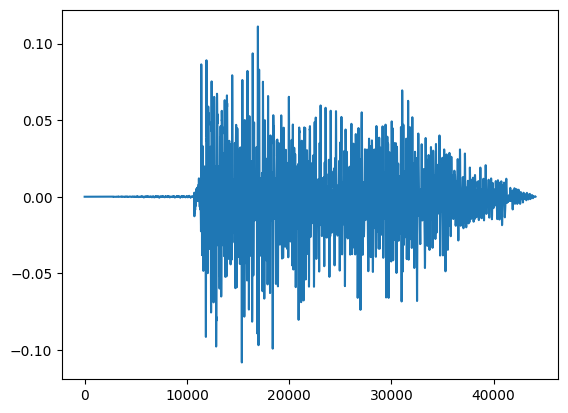

In [10]:
wave1, sr1 = librosa.load(bass_list['file_path'][1])
plt.plot(wave1)

#### Start preprocessing

We can start the preprocessing based on this dataset.

First we'll only use an arbitrary portion of the sounds, aka we'll truncate our wave length as to fasten computation.

In [11]:
length_before = 1000
length_after = 5000

In [12]:
def select_starting_point(y, length_before=1000, length_after=5000):
    start_ind = 0
    for i in range(len(y)):
        if y[i] >= 0.9 * y.max():
            start_ind = i
            break

    y_select = y[start_ind-length_before:start_ind+length_after].copy()
    return y_select


array([ 0.06114454,  0.05922422,  0.05748311, ..., -0.05447368,
       -0.05550012, -0.05642849], shape=(6000,), dtype=float32)

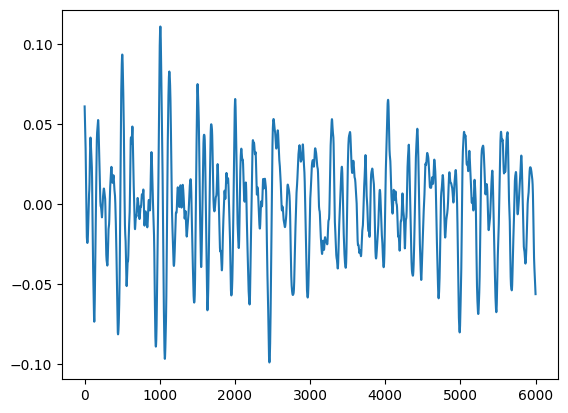

In [13]:
wave1_select = select_starting_point(wave1)
plt.plot(wave1_select)
wave1_select

#### processe dataset

In [14]:
def load_and_truncate(path, sr=22050):
    """
    Load audio file, resample, and pad/truncate to fixed length.

    Args:
        path (str): Path to audio file
        sr (int): Target sample rate (default 22050 Hz)
        max_len (int): Desired length in samples (default 5 seconds)

    Returns:
        np.ndarray: 1D array of length max_len
    """
    y, _ = librosa.load(path, sr=sr,dtype=np.float32)  # load audio
    #detect starting point of note
    y_select = select_starting_point(y)
    return y_select

In [15]:
sample_type = load_and_truncate(bass_list['file_path'][0])
print(f'the resulting is an {type(sample_type)} of dtype {sample_type.dtype} of length {len(sample_type)}')

the resulting is an <class 'numpy.ndarray'> of dtype float32 of length 6000


## Load the Dataset

*Beware, compution heavy*

In [16]:
X = bass_list['file_path'].apply(lambda x : load_and_truncate(x))
y = bass_list['note_name']

We loaded our entire data set, and it's target.

In [17]:
print(f'X is loaded with {len(X)} samples of {len(X[0])} samples each')
print(f'each X is of type {type(X[0])} and dtype {X[0].dtype}')
print (f'While the target y is of type {type(y)} with {len(y.unique())} labels, for example {y[0]}')

X is loaded with 20592 samples of 6000 samples each
each X is of type <class 'numpy.ndarray'> and dtype float32
While the target y is of type <class 'pandas.core.series.Series'> with 28 labels, for example E1


We transform our list of arrays into a np.array of float32.

In [18]:
X = np.stack(X).astype(np.float32)
X.shape

(20592, 6000)

X shape: (20592, 6000), X type : <class 'numpy.ndarray'> ,X[0].shape: (6000,), X[0] type : float32, y shape: (20592,)
Example X[0] length: 6000, y[0]: E1


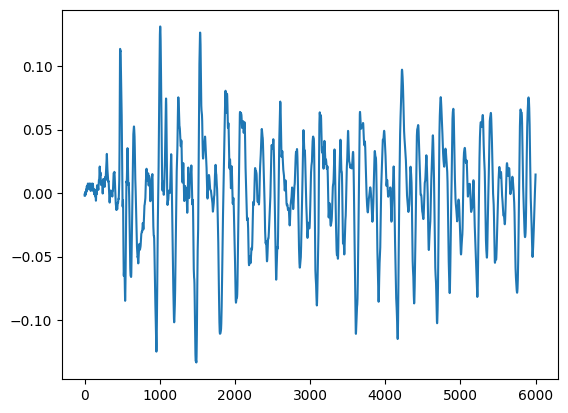

In [19]:
print(f'X shape: {X.shape}, X type : {type(X)} ,X[0].shape: {X[0].shape}, X[0] type : {X[0].dtype}, y shape: {y.shape}')
print(f'Example X[0] length: {len(X[0])}, y[0]: {y[0]}')
plt.plot(X[0])

In [20]:
classes = len(y.unique())
classes

28

We still have our sample size, our data and target classes preserved

#### encode y labels aka Notes

In [33]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

le = LabelEncoder()
y_int = le.fit_transform(bass_list['note_name'])  # integers 0..n_classes-1
y = to_categorical(y_int)

In [37]:
categories = y.shape[1]
categories

28

## TODO : analyze this partAnother step of preprocessing, i have to get back to this

In [ ]:
"""
Preprocess of features, not sure yet what it does.

X_features = chorus_bass_list['file_path'].apply(
    lambda x: librosa.feature.mfcc(
        y=librosa.load(WORKING_DIR + '/raw_data/' + x)[0],
        sr=librosa.load(WORKING_DIR + '/raw_data/' + x)[1],
        n_mfcc=13
    ).mean(axis=1)  # average over time → fixed-length vector
)

X = np.vstack(X_features.values).astype(np.float32)
"""

"\nPreprocess of features, not sure yet what it does.\n\nX_features = chorus_bass_list['file_path'].apply(\n    lambda x: librosa.feature.mfcc(\n        y=librosa.load(WORKING_DIR + '/raw_data/' + x)[0],\n        sr=librosa.load(WORKING_DIR + '/raw_data/' + x)[1],\n        n_mfcc=13\n    ).mean(axis=1)  # average over time → fixed-length vector\n)\n\nX = np.vstack(X_features.values).astype(np.float32)\n"

## Now let's split our data into our training/testing set

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [40]:
print(len(X[0]),len(y[0]),X[0].shape)
print(len(X_train[0]), len(y_train[0]) , X[0].shape)
print( len(X_train), len(X_test),len(y_train), len(y_test))

6000 28 (6000,)
6000 28 (6000,)
14414 6178 14414 6178


In [41]:
input_shape = (X[0].shape[0],1)
input_shape

(6000, 1)

### This is a test of Dense NN 

In [45]:
## create dense model and compile dense model :
def make_model(input_shape):
    input_layer = layers.Input(shape=input_shape)

    conv1 = layers.Conv1D(filters=256, kernel_size=3, padding="same")(input_layer)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)

    conv2 = layers.Conv1D(filters=256, kernel_size=3, padding="same")(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)

    conv3 = layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)

    gap = layers.GlobalAveragePooling1D()(conv3)

    output_layer = layers.Dense(categories, activation="softmax")(gap)

    return models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 6000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 6000, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6000, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 6000, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 6000, 256)      │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 6000, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 6000, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 6000, 64)       │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 6000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,228 (981.36 KB)

 Trainable params: 250,076 (976.86 KB)

 Non-trainable params: 1,152 (4.50 KB)

Dense NN commented, it's only 0.10 accuracy.

In [ ]:
"""
es = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[es])
"""

In [ ]:
print(f'{round(max(history.history['accuracy']),4)} is our best accuracy on training data with a Conv1D model')

In [ ]:
results = model.evaluate(X_test, y_test)
print(f'{round(results[1],4)} is our accuracy on test data with a Conv1D model')

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.0605 - loss: 3.3054
0.06 is our accuracy on test data with a Conv1D model


### test with a random forest

In [23]:
from sklearn.model_selection import cross_validate

In [26]:
# create a randomforest model to try and output the note based on the audio file
rf_classifier = RandomForestClassifier(n_estimators=100,max_depth=None,random_state=42)

results = cross_validate(rf_classifier, X_train, y_train, cv=10,scoring='accuracy')
results['test_score'].mean()

np.float64(0.975440560329021)

In [27]:
rf_classifier.fit(X_train,y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [28]:
rf_classifier.score(X_test,y_test)

0.9755584331498867

In [29]:
import pickle

with open("modele.pkl", "wb") as f:
    pickle.dump(rf_classifier, f)

In [ ]:
#grid search the random forest
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint



# Définir une grille d'hyperparamètres
param_grid = {
'n_estimators': randint(50, 300),
'max_depth': randint(0,5),
'min_samples_split': randint(2,11),
'min_samples_leaf': randint(1,11),
'min_impurity_decrease': uniform(0.0, 0.5),
}

# Recherche par grille
grid_search = RandomizedSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres :", grid_search.best_params_)

Meilleurs paramètres : {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


## Trying to rather go for the frequencies as a regression.

In [77]:
y_reg = chorus_bass_list['fréquence (Hz)']  #regression task

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X,y_reg, test_size=0.3)

ValueError: Found input variables with inconsistent numbers of samples: [1872, 3492]

In [ ]:
"""
Snippet pour entraîner et sélectionner le meilleur modèle parmi plusieurs régressions avec GridSearchCV.

Ce code définit :
- Un dictionnaire de modèles (GradientBoosting, RandomForest, LinearRegression, DecisionTree, SVR, AdaBoost, XGBRegressor).
- Un dictionnaire d'hyperparamètres associés.
- Une boucle itérative qui entraîne chaque modèle avec GridSearchCV et conserve le meilleur.
"""
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# dictionary of model to search on
models = {
    'model_gbm': GradientBoostingRegressor(),
    'model_rf': RandomForestRegressor(),
    'model_ln': LinearRegression(),
    'model_dt': DecisionTreeRegressor(),
    'model_svm': SVR(),
    'model_ada': AdaBoostRegressor(),
    'model_xgb': XGBRegressor()
}

# dictionary of hyperparameters
params = {
    'model_gbm': {'model__learning_rate':[0.1,0.2,0.3,0.4], 'model__n_estimators':[50,100,500,1000,2000], 'model__max_depth':[3,5,7]},
    'model_rf': {'model__n_estimators':[50,100,500,1000,2000], 'model__max_depth':[2,5,7,10,20]},
    'model_dt': {'model__splitter':['best','random'], 'model__max_depth':[2,5,7,10,20,50]},
    'model_svm': {'model__C':[1,2,5,10,50,100,500], 'model__kernel':['rbf','poly','sigmoid','linear'], 'model__degree':[2,3,4], 'model__gamma':['scale','auto']},
    'model_ada': {'model__n_estimators':[10,20,30,50,100,500,1000], 'model__learning_rate':[0.5,1,2,5,10]},
    'model_xgb': {'model__n_estimators':[50,100,500,1000], 'model__learning_rate':[0.01,0.05,0.1,0.2], 'model__max_depth':[3,5,7,10]}
}

# initialize a dictionary
best_models = {}

# iterating loops through models and params
for name, model in models.items():
    print(f"Training and tuning {name}...")
    final_pipe = Pipeline([
        ('model', model)
    ])
    grid = params.get(name, {})
    search = GridSearchCV(final_pipe, grid, scoring=['neg_mean_squared_error'], cv=5, n_jobs=-1)
    search.fit(X_reg_train, y_reg_train)
    best_models[name] = search.best_estimator_
    print(f"{name}: Best params -> {search.best_params_}, Score -> {search.best_score_}")

Training and tuning model_gbm...


ValueError: For multi-metric scoring, the parameter refit must be set to a scorer key or a callable to refit an estimator with the best parameter setting on the whole data and make the best_* attributes available for that metric. If this is not needed, refit should be set to False explicitly. True was passed.